# Test technique Equancy
## Julien Lambert

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, f1_score, silhouette_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm # je me suis permis d'ajouter une librairie pour afficher des barres de chargement

In [3]:
data = pd.read_csv("data.csv")
data.head(3)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes


In [4]:
# Formatage de la colomne Experience
data.Experience = data.Experience.str.replace(',','.').astype(float)
data.isnull().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

Il existe des duplicatas, la stratégie à adopter dépend de la nature du dataset :

- Si les variables "Entreprise" et "Ville" correspondent à l'emploi et à la ville actuelle du candidat
    ==> Il est peu probable qu'il existe 2 candidats ayant la même expérience, ville, entreprise et technologies postulant pour le même poste. J'émets l'hypothèse que ce sont des candidats ayant postulé plusieurs fois et je retire les doublons.
- Si ces variables correspondent à l'entreprise pour laquelle la personne candidate ainsi que le lieu du poste
    ==> Il est probable que des candidats ayant les mêmes compétences et expérience postulent pour le même poste, je ne retire pas les doublons.

Il faudrait s'informer auprès du client pour en savoir plus. Ici, je vais supposer la première hypothèse.


In [5]:
data[data.duplicated()].isna().sum() # Ces duplicatas ne sont pas dû aux valeurs nulles

Entreprise      0
Metier          0
Technologies    0
Diplome         0
Experience      0
Ville           0
dtype: int64

In [6]:
print("Nb duplicats : " + str(len(data) - len(data.drop_duplicates())))
print("Nb duplicats sans considérer la variable Metier : " + str(len(data) - len(data.drop('Metier', axis=1).drop_duplicates())))
# Il est aussi probable que ces candidats aient postulé pour la même entreprise mais à 2 postes similaires

data_filtered = data.copy().drop_duplicates(subset=list(data.columns).remove("Metier"))
print("Taille du dataset sans duplicats : " + str(len(data_filtered)))

Nb duplicats : 32
Nb duplicats sans considérer la variable Metier : 38
Taille du dataset sans duplicats : 9550


## 1) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes 

Ce dataset contient 9 582 candidats mais si mes 2 hypothèses sont correctes il existe en réalité 9 550 candidats

## 2) Réaliser l'imputation des valeurs manquantes pour la variable "Experience"

a. la valeur médiane pour les data scientists\
b. la valeur moyenne pour les data engineers



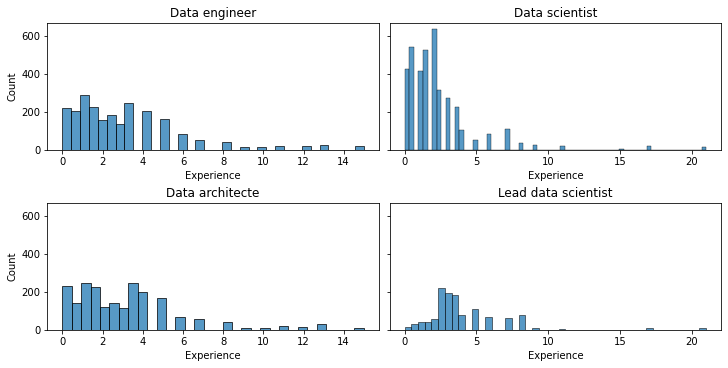

In [7]:
# On visualise la distribution de l'expérience pour chaque Métier
fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharey=True, constrained_layout=True)

sns.histplot(data_filtered[data_filtered.Metier == 'Data engineer'].Experience, ax = axes[0,0])
sns.histplot(data_filtered[data_filtered.Metier == 'Data scientist'].Experience, ax = axes[0,1])
sns.histplot(data_filtered[data_filtered.Metier == 'Data architecte'].Experience, ax = axes[1,0])
sns.histplot(data_filtered[data_filtered.Metier == 'Lead data scientist'].Experience, ax = axes[1,1])

axes[0,0].set_title("Data engineer")
axes[0,1].set_title("Data scientist")
axes[1,0].set_title("Data architecte")
axes[1,1].set_title("Lead data scientist")
plt.show()

La distribution des data scientists est déséquilibrée => mediane \
La distribution des data engineers et architectes est à peu près symétrique et celle des Lead data scientists est à peu près normale => moyenne


In [8]:
# Remplacement des valeurs nulles

exp_med_data_scientist = data_filtered[data_filtered.Metier == 'Data scientist'].Experience.median()
exp_moy = data_filtered.groupby('Metier').Experience.mean()

data_filtered.loc[(data_filtered.Metier == 'Data scientist') & (data_filtered.Experience.isnull()), "Experience"] = exp_med_data_scientist
data_filtered.loc[(data_filtered.Metier == 'Data engineer') & (data_filtered.Experience.isnull()), "Experience"] = exp_moy['Data engineer']
data_filtered.loc[(data_filtered.Metier == 'Data architecte') & (data_filtered.Experience.isnull()), "Experience"] = exp_moy['Data architecte']
data_filtered.loc[(data_filtered.Metier == 'Lead data scientist') & (data_filtered.Experience.isnull()), "Experience"] = exp_moy['Lead data scientist']

## 3) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne ?

Je constate que vous n'avez pas mentionné le profil data architecte, je suppose que c'est un oubli

In [9]:
exp_moy = data_filtered.groupby('Metier').Experience.mean()
print(exp_moy.round(1).to_string())

Metier
Data architecte        3.0
Data engineer          3.0
Data scientist         2.2
Lead data scientist    4.0


## 4) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

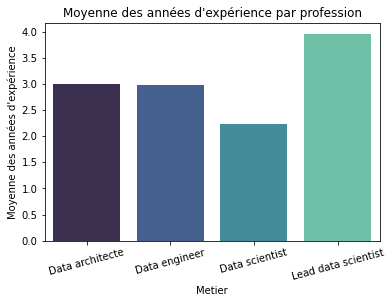

In [10]:
sns.barplot(x=exp_moy.index, y=exp_moy, palette='mako')
plt.xticks(rotation=15)
plt.ylabel("Moyenne des années d'expérience")
plt.title("Moyenne des années d'expérience par profession")

plt.show()

## 5) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités : débutant, confirmé, avancé et expert.
Veuillez expliquer votre choix de la règle de transformation.

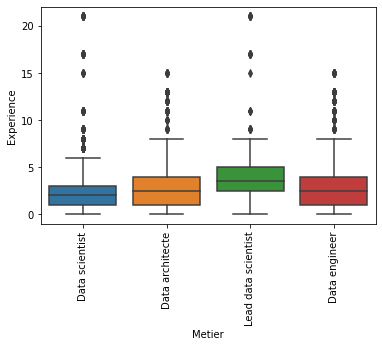

In [11]:
sns.boxplot(y="Experience", x='Metier', data=data_filtered )
plt.xticks(rotation=90)
plt.show()

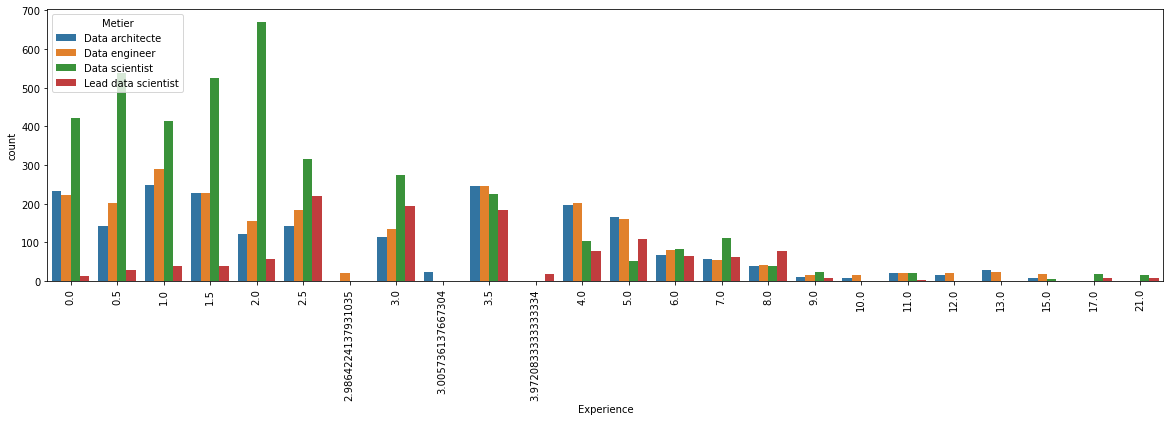

In [12]:
plt.figure(figsize=(20,5))
sns.countplot(hue='Metier', x='Experience', data=data_filtered.sort_values(by=['Metier','Experience']), )
plt.xticks(rotation=90)
plt.show()

- Si cette discrétisation a pour but de simplifier les analyses futures/faire des visualisations => discrétisation différente selon le métier\
- Sinon, si le but de l'opération est de simplifier la variable Experience pour améliorer la prédiction des métiers => discrétisation tous métiers confondus car on ne pourra pas discrétiser le test_set 

Ici je vais faire comme si c'était le 2ème cas, on choisira les valeurs seuils des bins de manière à séparer les métiers.\
Par exemple de 0 à 2.5 ans d'expérience, les Lead data scientists sont peu nombreux, de 0 à 3.5 ans les data scientists forment la classe dominante, etc.

In [13]:
data_filtered['Exp_label'] = pd.cut(data_filtered.Experience, bins=[-1, 2.5, 3.5, 9, 400], labels=["débutant", 'confirmé', 'avancé', 'expert'])

## 6) Quelles sont les 5 technologies les plus utilisées ? Faites un graphique

In [14]:
# One hot encodage des compétences techniques

# Strings en listes
tech_list = data_filtered.Technologies.str.lower().str.split("/")

# One hot encodage des skills
mlb = MultiLabelBinarizer()
tech_encoded = pd.DataFrame(mlb.fit_transform(tech_list), columns=mlb.classes_)

# Fusion des skills nosq et nosql
tech_encoded['nosql'] = (tech_encoded.nosq | tech_encoded.nosql)
tech_encoded.drop(['nosq', ''], axis=1, inplace=True)

# Calcul des proportions de présence des skills dans les candidatures
tech_count = tech_encoded.sum().sort_values() / len(tech_encoded) * 100

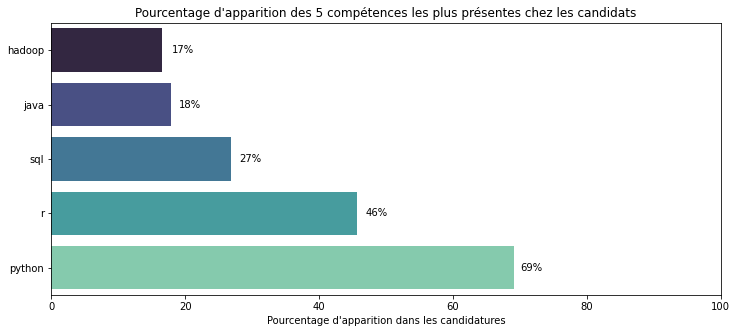

In [15]:
# Le diagramme à barres horizontal permet d'associer clairement la compétence à son pourcentage
plt.figure(figsize=(12, 5))
sns.barplot(x=tech_count.tail(5), y=tech_count.tail(5).index, orient='h', palette='mako')
plt.title("Pourcentage d'apparition des 5 compétences les plus présentes chez les candidats")
plt.xticks(range(0, 120, 20))
plt.xlabel("Pourcentage d'apparition dans les candidatures")

# Affichage des pourcentages
percentages = tech_count.tail(5).round().astype(int)
for i, v in enumerate(percentages):
    plt.annotate(str(v) + '%', xy=(v + 1, i), va='center')

plt.show()


# 7) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître le nombre de clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.

In [16]:
# L'anglais, python et windows ne sont pas des conaissances spécifiques
tech_encoded.drop(["anglais", "windows", "python"], axis=1, inplace=True)

In [17]:
# Concaténation de la matrice binaire de skills et des autres features
tech_cols = tech_encoded.columns
data_filtered.reset_index(drop=True, inplace=True)
tech_encoded.reset_index(drop=True, inplace=True)
tech_encoded = pd.concat([tech_encoded, data_filtered], axis=1)

Je vais utiliser un clustering agglomeratif, et en particulier la fonction clustermap() de seaborn car elle permet de visualiser rapidement les clusters de lignes et colomnes. Le clustering agglomeratif est un clustering hierearchique, ce qui permet de visualiser les clusters à différents niveaux, et donc de choisir le nombre de clusters en fonction des résultats de l'algorithme.\
J'ai choisi la mesure de distance Dice qui représente la similarité entre 2 clusters, j'ai aussi testé la mesure Jaccard et Hamming.

J'aurais également tenté le clustering k-modes si les librairies autorisées n'étaient pas limitées

C:\Users\ju_la\Anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


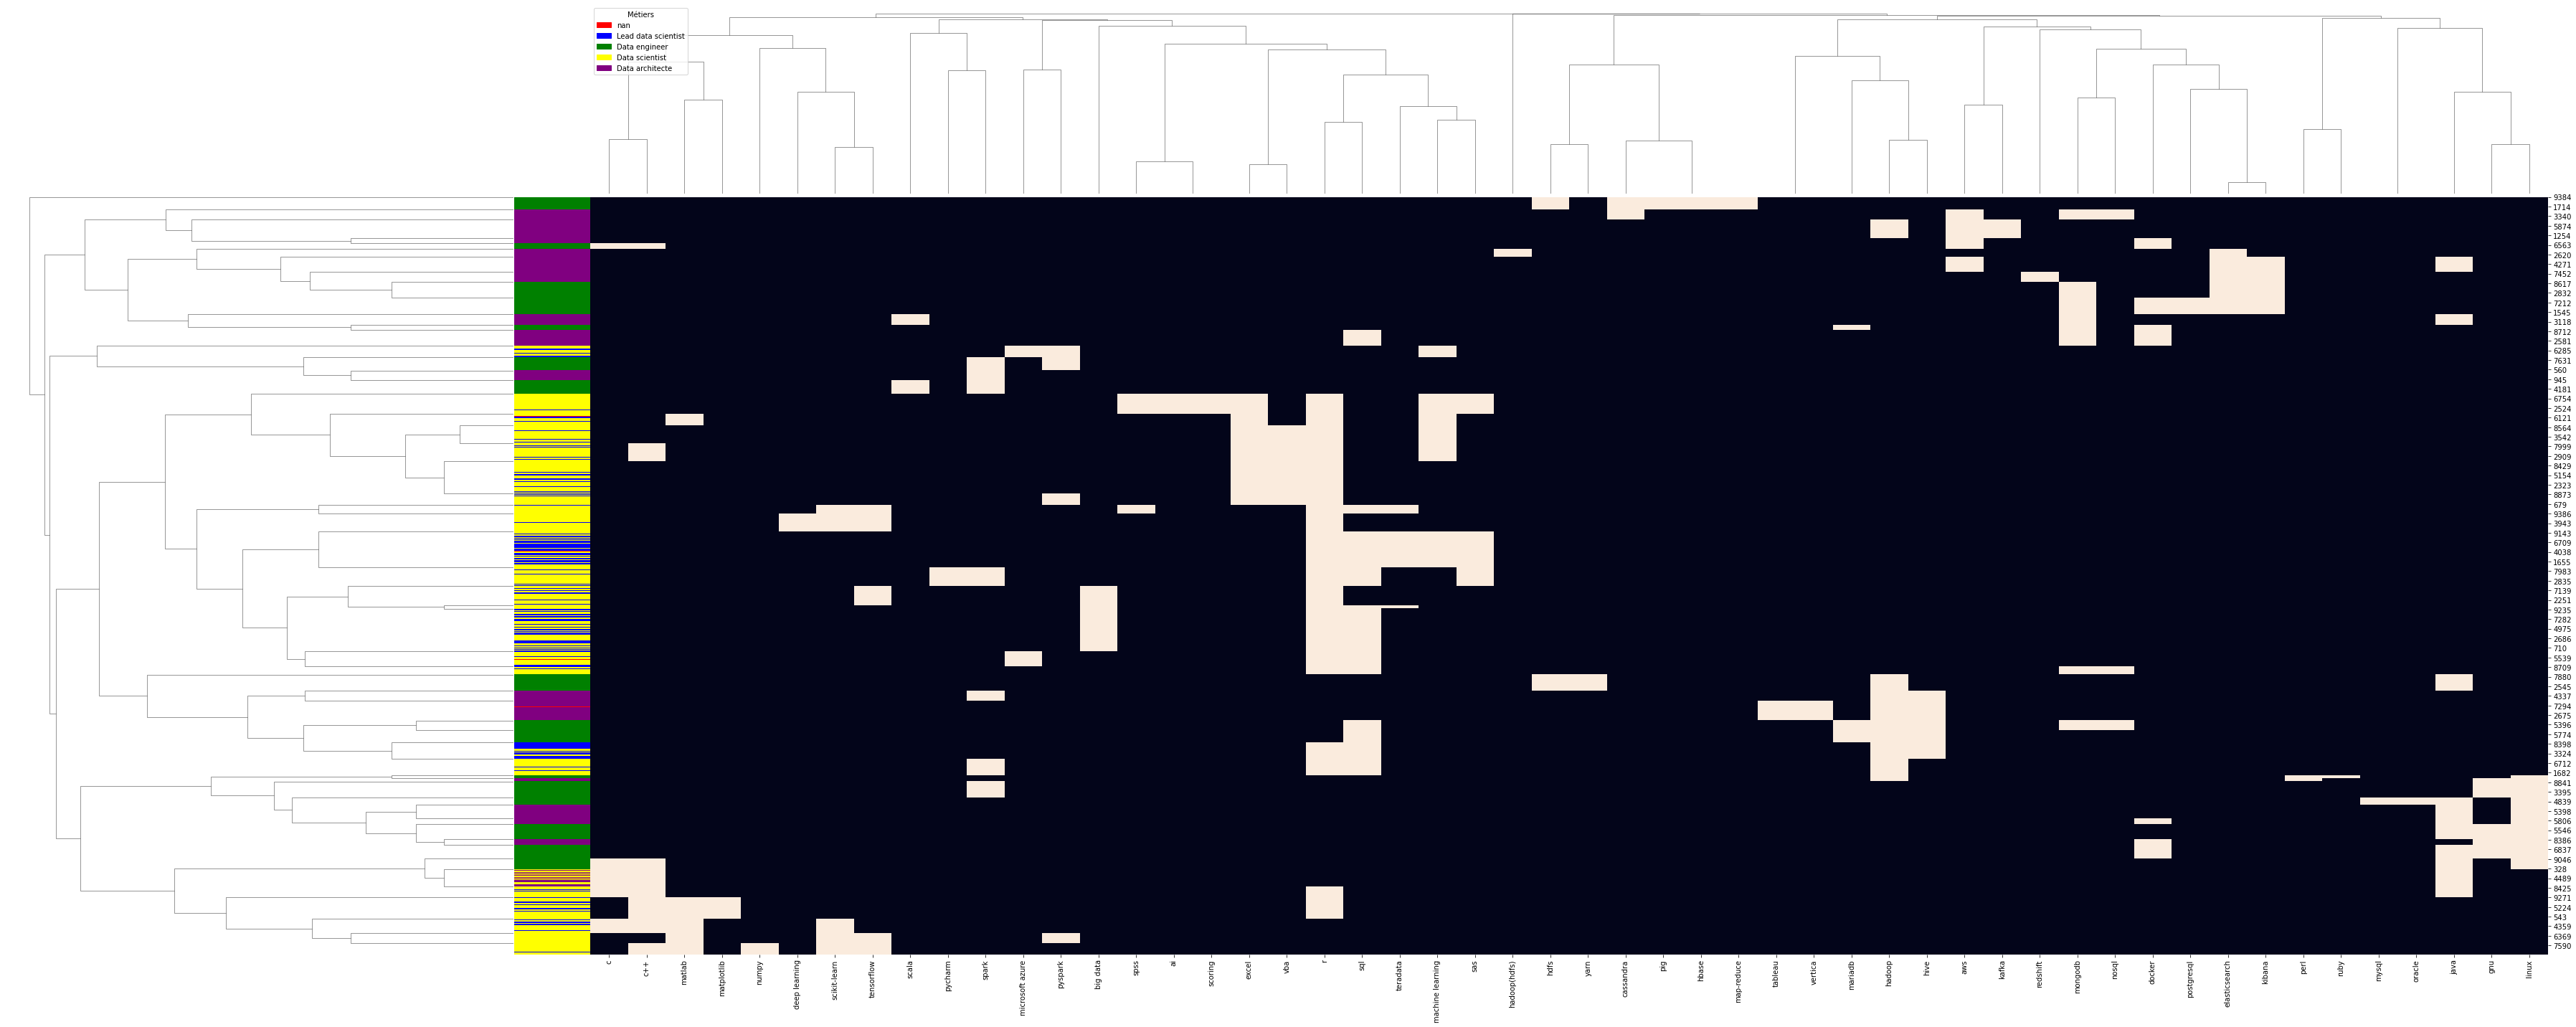

In [18]:
metiers = tech_encoded.Metier
metiers_colors = ['red', 'blue', 'green', 'yellow', 'purple']

# Création d'un dictionnaire pour mapper les métiers aux couleurs
metiers_color_map = dict(zip(set(metiers), metiers_colors))

# Attribution des couleurs selon le metier
row_colors = [metiers_color_map[i] for i in metiers]

# Création d'une clustermap avec une barre verticale de couleurs (métiers associés aux candidats)
clustermap = sns.clustermap(tech_encoded[tech_cols],  metric='dice', figsize=(50,20), row_colors=row_colors, method='average')

# Ajout de légende de la barre verticale
barre = clustermap.ax_col_dendrogram
legende = [plt.Rectangle((0, 0), 1, 1, color=i) for i in metiers_color_map.values()]
barre.legend(legende, metiers_color_map.keys(), loc='upper left', title='Métiers')

# Suppression de la légende de la matrice
clustermap.cax.set_visible(False) 
plt.show()

On identifie visuellement 5 principaux groupes de profils techniques :  
- Cluster 1 : R, SQL, Excel, Machine Learning, VBA, Big Data, Sas
- Cluster 2 : C, C++, Matlab, Java, Scikit-learn
- Cluster 3 : Hive, Hadoop, SQL, R
- Cluster 4 : MongoDB, ElasticSeach, Kibana
- Cluster 5 : Linux, GNU, Java

Ces clusters sont également identifiés par le dendrogramme latéral 

La barre latérale de couleur représente les métiers associés aux candidats, le clustering permet de différencier les Lead Data Scientists/Data scientists des Data architectes/Data engineers, cependant il faut un plus grand nombre de cluster pour différencier les 4 métiers.

Calculons le score de silhouette en fonction du nombre de clusters, j'utilise l'AgglomerativeClustering de sklearn mais de mémoire scipy permet de couper le dendrogramme à la distance voulue et d'extraire les clusters

 

In [19]:
sil_scores = []
for i in tqdm(range(10, 70, 5)):
    clustering = AgglomerativeClustering(metric = 'dice', n_clusters=i, linkage='average')
    labels = clustering.fit_predict(tech_encoded[tech_cols])

    avg_silhouette = silhouette_score(tech_encoded[tech_cols], labels, metric='dice')
    sil_scores.append(avg_silhouette)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]C:\Users\ju_la\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
  8%|██████▉                                                                            | 1/12 [00:08<01:36,  8.80s/it]C:\Users\ju_la\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
 17%|█████████████▊                                                                     | 2/12 [00:18<01:36,  9.61s/it]C:\Users\ju_la\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
 25%|████████████████████▊                                               

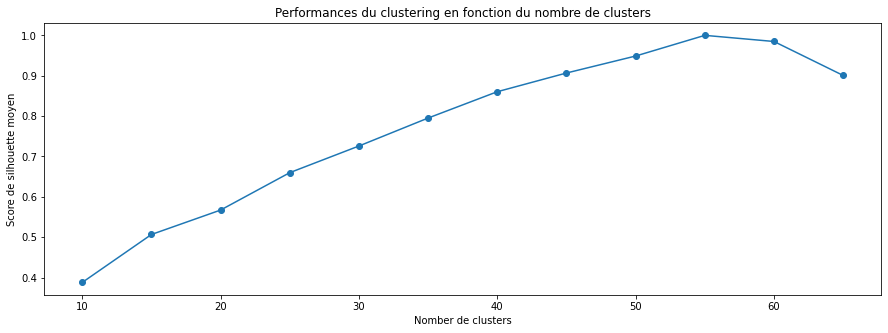

In [20]:
plt.figure(figsize=(15,5))
plt.plot(range(10, 70, 5), sil_scores, 'o-')
plt.xlabel('Nomber de clusters')
plt.ylabel('Score de silhouette moyen')
plt.title('Performances du clustering en fonction du nombre de clusters')
plt.show()

Comme le dataset est binaire, le maximum de la courbe est atteint lorsque le nombre de clusters est égale au nombre de combinaisons binaires uniques (54). Or le fait d'utiliser 54 clusters ne permet pas de bien généraliser à de nouveaux candidats.\
Nous prendrons donc 30 clusters car à partir de 0.7 le clustering peut être considéré comme satisfaisant.

C:\Users\ju_la\Anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


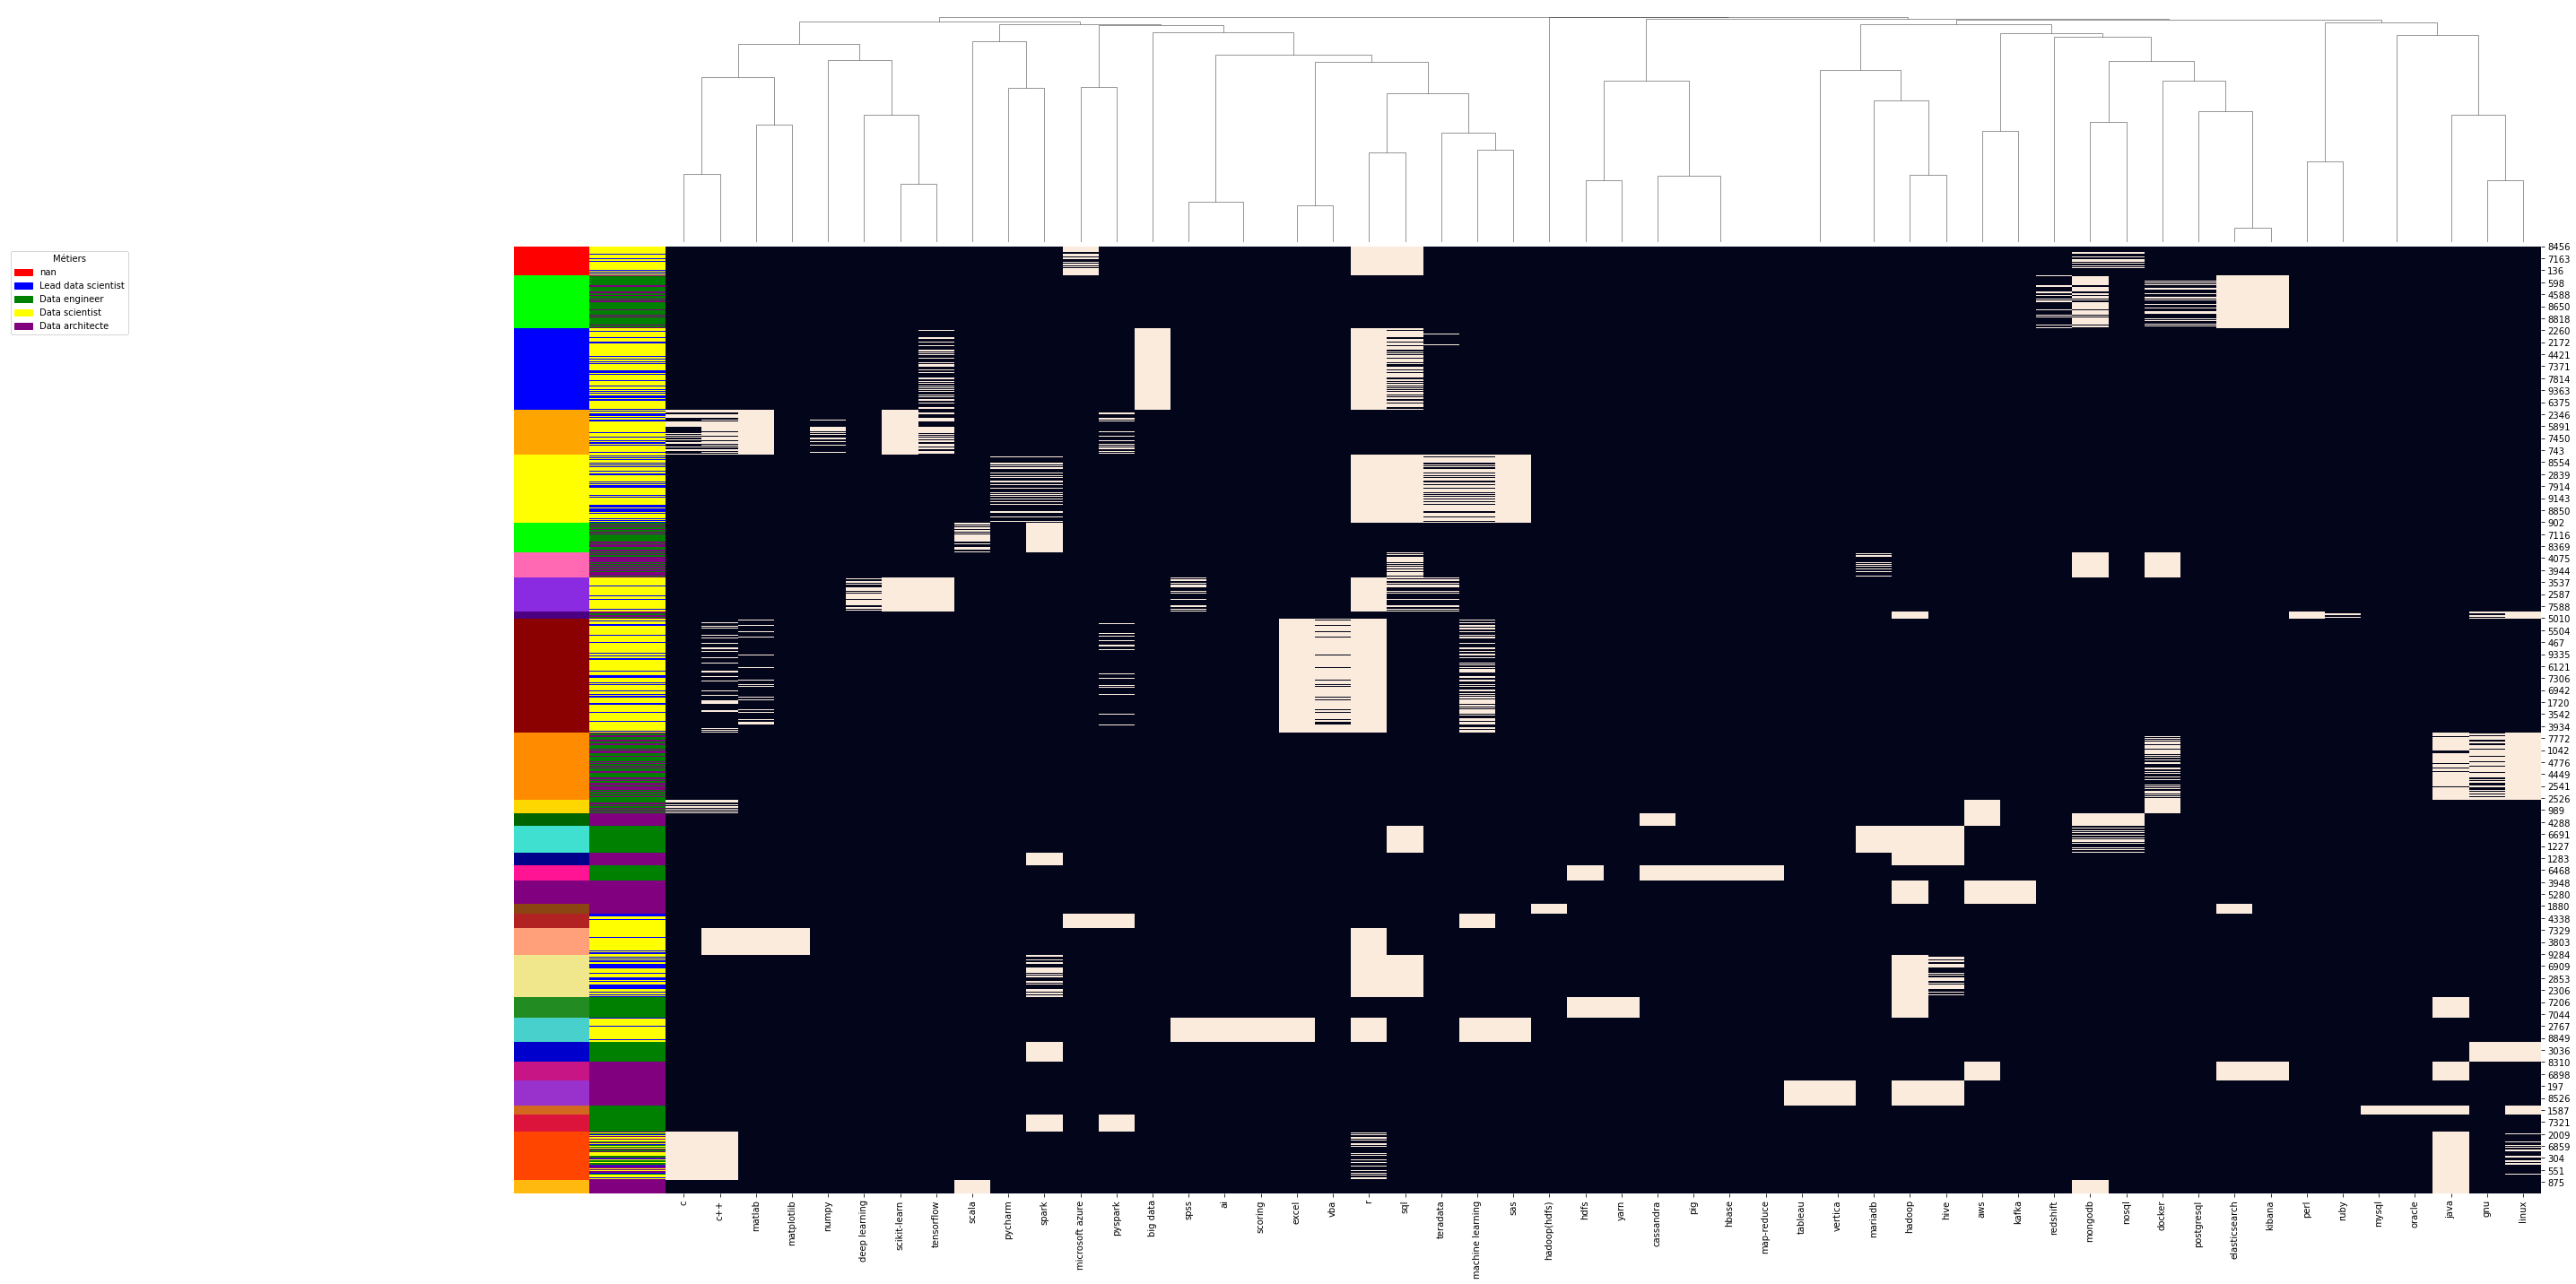

In [21]:
custom_palette = [
    '#FF0000', '#00FF00', '#0000FF',  
    '#FFA500', '#FFFF00', '#00FF00',  
    '#FF69B4', '#8A2BE2', '#4B0082',  
    '#8B0000', '#FF8C00', '#FFD700',  
    '#006400', '#40E0D0', '#00008B',  
    '#FF1493', '#800080', '#8B4513',  
    '#B22222', '#FFA07A', '#F0E68C',  
    '#228B22', '#48D1CC', '#0000CD',  
    '#C71585', '#9932CC', '#D2691E',  
    '#DC143C', '#FF4500', '#FFB90F',  
    '#3CB371', '#20B2AA', '#000080',  
    '#FF00FF', '#8B008B', '#A0522D',  
    '#A52A2A', '#FF7F50', '#F4A460',  
]

# Clustering des candidats
clustering = AgglomerativeClustering(metric="dice", n_clusters=30, linkage='average')
labels = clustering.fit_predict(tech_encoded[tech_cols])

# Ajout des clusters au dataset et groupement
tech_encoded['clust'] = labels
tech_encoded.sort_values(by='clust', inplace=True)

metiers = tech_encoded.Metier
clusters = tech_encoded.clust
metier_colors = ['red', 'blue', 'green', 'yellow', 'purple']
cluster_colors = custom_palette

# Création d'un dictionnaire pour mapper les métiers/clusters aux couleurs
cluster_color_map = dict(zip(set(clusters), cluster_colors))
metier_color_map = dict(zip(set(metiers), metier_colors))

# Attribution des couleurs selon le metier/cluster
clust_colors = [cluster_color_map[i] for i in clusters]
job_colors = [metier_color_map[i] for i in metiers]

# Création d'une clustermap avec 2 barres de couleurs : métiers et clusters. 
# On ne clusterise que les colonnes pour respecter les clusters de l'Agglomerative clustering
clustermap = sns.clustermap(tech_encoded[tech_cols], row_cluster=False, col_cluster=True, metric='dice', figsize=(40,20), row_colors=[clust_colors, job_colors], method='average')

# Ajout de la légende de la barre verticale
barre = clustermap.ax_row_dendrogram
legende = [plt.Rectangle((0, 0), 1, 1, color=i) for i in metier_color_map.values()]
barre.legend(legende, metiers_color_map.keys(), loc='upper left', title='Métiers')

# Suppression de la légende de la matrice
clustermap.cax.set_visible(False) 
plt.show()

En partant de la gauche, la première barre verticale représente les clusters trouvés, et la seconde les métiers.\
On peut remarquer qu'avec 30 clusters, les clusters commencent à être spécifiques au métier

### a. Justifier le nombre de clusters

Si l'on veut identifier les groupes de profils techniques on peut visuellement identifier 5 clusters principaux.\ 
En revanche si le but est d'améliorer les performances d'un modèle de prédiction, il est recommandé d'augmenter le nombre de clusters à 30 au minimum. Cela permet de séparer plus clairement les data architectes, engineers et scientists.

### b. Justifier la performance de votre algorithme grâce à une métrique.

J'ai choisi d'utiliser le score de silhouette qui représente à quel point les candidats sont bien regroupés dans leurs clusters et sont séparés des autres clusters.
Nous pourrions atteindre le score maximal de 1 car nous utilisons un dataset binaire mais pour mieux généraliser à de nouvelles données nous nous limitons à un score de 0.7.

### c. Interpréter votre résultat.

Les data scientists et lead data scientists sont difficiles à séparer en clusters car ils ont la même base de compétences. De plus ces 2 métiers ont des profils techniques uniformes, c'est un peu moins le cas pour les 2 autres métiers qui semblent être divisés en 3 clusters de profil techniques.
Je trouve en revanche que l'algorithme de la clustermap de seaborn donne de meilleurs résultats que l'Agglomerative clustering de sklearn, avec scipy il serait possible d'en extraire les clusters.

# Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix

Après avoir testé différents algorithmes, j'ai décidé d'utiliser un Gradient Boosting Classifier, il ne nécessite pas de sélection de feature et leur donne un score d'importance. De plus, il est résistant au sur-apprentissage.\
J'ai manuellement tunné le modèle en utilisant une validation stratifiée croisée, mais j'aurais pu utiliser des méthodes comme une grid search

#### a) Justifier la performance de votre algorithme grâce à une métrique.
J'utilise le score f1 qui permet de combiner la précision et le recall, j'utilise aussi une matrice de confusion afin d'avoir une idée des défauts du modèle

In [22]:
# One Hot Encodage des variables catégoriques

# Il reste 17 valeurs nulles dans la colonne Entreprise, étant donné qu'il n'en existe pas dans le set à prédire nous allons les retirer
# Si le but est de mettre le modèle en production, on transformera les valeures nulles en un label
df=tech_encoded.copy()
df = df[df.Entreprise.isna()==False]

df_encoded = pd.concat([pd.get_dummies(df[['Entreprise', 'Ville', 'Diplome', 'clust']], drop_first=True), df], axis=1)
df_encoded = df_encoded.drop(['Entreprise', 'Ville', 'Diplome', 'clust', "Technologies", "Exp_label"], axis=1)

# Normalisation de la variable Expérience
df_encoded.Experience = (df_encoded.Experience - df_encoded.Experience.min()) / (df_encoded.Experience.max() - df_encoded.Experience.min())

In [23]:
# Séparation des lignes à prédire
predict_set = df_encoded[df_encoded.Metier.isna()].drop("Metier", axis=1)
train_set = df_encoded.drop(predict_set.index)

# Encodage des métiers
metier_labels = dict(zip(train_set.Metier.unique(), range(len(train_set.Metier.unique()))))
train_set.Metier = train_set.Metier.replace(metier_labels)

# Split stratifié
'''x_train, x_test, y_train, y_test = train_test_split(train_set.drop("Metier", axis=1), train_set.Metier, test_size=0.2, stratify=train_set.Metier, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)'''

'x_train, x_test, y_train, y_test = train_test_split(train_set.drop("Metier", axis=1), train_set.Metier, test_size=0.2, stratify=train_set.Metier, random_state=42)\nx_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)'

In [24]:
# Validation stratifiée croisée

models = []
f1s = 0
skf = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)

for i, (train_index, test_index) in enumerate(skf.split(train_set.drop("Metier", axis=1), train_set.Metier)):
    x_train, y_train = train_set.iloc[train_index].drop("Metier", axis=1), train_set.iloc[train_index].Metier
    x_test, y_test = train_set.iloc[test_index].drop("Metier", axis=1), train_set.iloc[test_index].Metier
    
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.4,  max_depth=3, random_state=0).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(confusion_matrix(y_test, y_pred))
    f1 = f1_score(y_test, y_pred, average='micro')
    print(f1)
    f1s += f1
    
    models.append(model)
    
print("Score F1 moyen : "+str(np.round(f1s/5, 3)))

[[704  63   4   0]
 [110 128   5   0]
 [  8   0 414   0]
 [  0   0   0 467]]
0.9001576458223857
[[716  45  10   0]
 [115 127   1   0]
 [ 11   0 411   0]
 [  0   1   0 466]]
0.9038360483447189
[[697  71   2   0]
 [121 120   2   0]
 [ 10   3 410   0]
 [  0   0   0 467]]
0.8901734104046243
[[704  63   3   0]
 [109 132   2   0]
 [  9   2 411   0]
 [  0   0   0 468]]
0.9012086179716238
[[692  64  14   0]
 [125 114   4   0]
 [  5   1 416   0]
 [  0   0   0 467]]
0.88801261829653
Score F1 moyen : 0.897


In [25]:
# Prédiction avec chaque modèle et séléction par le mode
preds = pd.DataFrame()
for i in tqdm(range(len(models))):
    preds[i] = models[i].predict(predict_set)
preds = preds.mode(axis=1)

# Création de la matrice de sortie
output = tech_encoded[tech_encoded.Metier.isna()].copy()
output["Metier"] = preds.values.flatten()
output.Metier.replace({value: key for key, value in metier_labels.items()}, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.61it/s]


In [30]:
output.head(3)

,ai,aws,big data,c,c++,cassandra,deep learning,docker,elasticsearch,excel,...,vertica,yarn,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,clust
4240,0,0,0,0,0,0,0,0,0,0,...,0,0,KPMG,Data scientist,Python/Microsoft Azure/R/SQL,Phd,2.0,Lyon,débutant,0
4284,0,0,0,0,0,0,0,0,0,0,...,0,0,Partners HealthCare(PHS),Lead data scientist,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8.0,Bordeaux,avancé,4
4282,0,0,0,0,0,0,0,0,0,0,...,0,0,"Pandora Media, Inc.",Data scientist,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,1.5,Toulouse,débutant,4


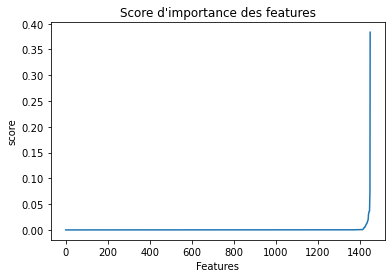

Nombre de feature ayant un score de 0.0 : 1027 sur 1450


In [27]:
# Importance des features selon le modèle (j'utilise un seul des modèles car ils ont les mêmes performances)
res = pd.DataFrame({"feature": x_train.columns, "score":models[0].feature_importances_}).sort_values(by='score')
sns.lineplot(data=res, x=range(len(res)), y="score")
plt.xlabel('Features')
plt.title("Score d'importance des features")
plt.show()
print("Nombre de feature ayant un score de 0.0 : "+str(len(res[res.score == 0.0]))+" sur "+str(len(res)))

In [28]:
res.tail(20)

,feature,score
1413,java,0.011094
1430,postgresql,0.011388
1400,c,0.012079
1416,linux,0.012203
1415,kibana,0.013755
1420,matlab,0.014327
1432,pyspark,0.016265
1447,vertica,0.017190
1442,sql,0.017985
1423,mongodb,0.019222


### b) Interpréter votre résultat.

J'obtiens un score f1 moyen de 0.89, en revanche les matrices de confusion indiquent que les modèles ont du mal à différencier les Lead Data Scientists des Data scientists. Cela s'explique par les compétences essentiellement similaires.

Un très grand nombre de variables ne sont pas utilisées par le modèle (les retirer l'améliore pas le modèle), et ce sont principalement les compétences techniques qui permettent au modèle de classifier. L'expérience est cependant la seconde variable la plus importante au modèle.

